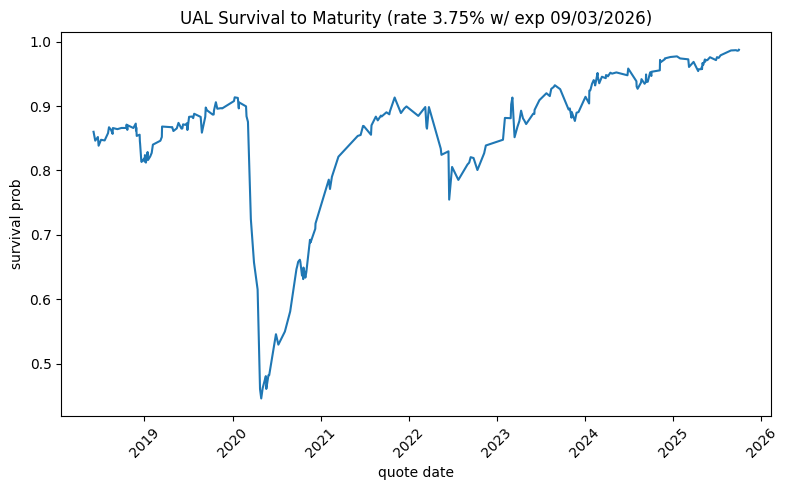

          date  last_value  spread_bps  spread_dec    hazard   tau_yrs  \
0   2018-06-04     109.617     109.617    0.010962  0.018270  8.254795   
1   2018-06-11     121.611     121.611    0.012161  0.020269  8.235616   
2   2018-06-22     117.185     117.185    0.011718  0.019531  8.205479   
3   2018-06-25     129.005     129.005    0.012900  0.021501  8.197260   
4   2018-07-05     121.420     121.420    0.012142  0.020237  8.169863   
5   2018-07-20     122.925     122.925    0.012292  0.020487  8.128767   
6   2018-08-03     113.665     113.665    0.011366  0.018944  8.090411   
7   2018-08-07     105.916     105.916    0.010592  0.017653  8.079452   
8   2018-08-16     110.066     110.066    0.011007  0.018344  8.054795   
9   2018-08-22     115.404     115.404    0.011540  0.019234  8.038356   
10  2018-08-23     107.574     107.574    0.010757  0.017929  8.035616   
11  2018-09-11     109.736     109.736    0.010974  0.018289  7.983562   

       s_tau  
0   0.860010  
1   0.8

In [141]:
#import libraries 

import pandas as pd, numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

#========================================

#loading csv 

file = r"C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\UAL_prices.csv"
df = pd.read_csv(file)


#keeping date to last in spread 

df = df.rename(columns={"Date":"date","Last":"last_value"}).loc[:,["date","last_value"]]

#========================================

#parse dates + numeric 

def dates(x):
    
    for fmt in ("%m/%d/%Y","%m/%d/%y","%Y-%m-%d"):
        
        try: return datetime.strptime(str(x), fmt).date()
        except: pass
    return pd.NaT


def tnum(x):
    
    s = str(x).replace(",", "").strip()
    
    try: return float(s)
    except: return np.nan
    

df["date"] = df["date"].apply(dates)
df["last_value"] = df["last_value"].apply(tnum)
df = df.dropna(subset=["date", "last_value"]).sort_values("date").reset_index(drop=True)

#========================================

#reduced form - spread, hzrd, survival probs 


df["spread_bps"] = df["last_value"]          
df["spread_dec"] = df["spread_bps"] / 1e4


#assuming recovery rate 

r = 0.4                                      
df["hazard"] = df["spread_dec"] / (1 - r)


#taking exp maturity from bond des

expm = datetime(2026, 9, 3).date()

df["tau_yrs"] = (pd.to_datetime(expm) - pd.to_datetime(df["date"])).dt.days / 365.0
df = df[df["tau_yrs"] >= 0].copy()


#calculating survival under constant hzrd to maturity 

df["s_tau"] = np.exp(-df["hazard"] * df["tau_yrs"])

#save as csv 

#saved = "/Users/anthonygiller/Downloads/UAL_reduced_form_survival.csv"
#df.to_csv("UAL_survival_to_maturity.csv", index=False)

#========================================

#plot survival prob 

plt.figure(figsize=(8,5))

plt.plot(df["date"], df["s_tau"])
plt.title("UAL Survival to Maturity (rate 3.75% w/ exp 09/03/2026)")
plt.xlabel("quote date") 
plt.ylabel("survival prob")

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()


print(df.head(12))


In [166]:
df[125:175]

,date,Time_to_Maturity,last_value,spread_bps,spread_dec,hazard,s_tau,Q_fit
125,2021-08-25,5.027397,155.630,155.630,0.015563,0.025938,0.877742,0.823216
126,2021-09-07,4.991781,146.627,146.627,0.014663,0.024438,0.885159,0.823811
127,2021-09-10,4.983562,148.775,148.775,0.014878,0.024796,0.883758,0.823950
128,2021-09-27,4.936986,142.307,142.307,0.014231,0.023718,0.889501,0.824746
129,2021-09-30,4.928767,141.466,141.466,0.014147,0.023578,0.890289,0.824889
130,2021-10-12,4.895890,146.738,146.738,0.014674,0.024456,0.887155,0.825464
131,2021-10-14,4.890411,141.162,141.162,0.014116,0.023527,0.891316,0.825560
132,2021-11-03,4.835616,112.588,112.588,0.011259,0.018765,0.913256,0.826541
133,2021-11-08,4.821918,119.595,119.595,0.011959,0.019932,0.908361,0.826790
134,2021-11-29,4.764384,148.002,148.002,0.014800,0.024667,0.889120,0.827853


In [143]:
df.rename(columns ={'tau_yrs': 'Time_to_Maturity'}, inplace=True)
df = df[['date', 'Time_to_Maturity', 'last_value', 'spread_bps', 'spread_dec', 'hazard', 's_tau']]
df

,date,Time_to_Maturity,last_value,spread_bps,spread_dec,hazard,s_tau
0,2018-06-04,8.254795,109.6170,109.6170,0.010962,0.018270,0.860010
1,2018-06-11,8.235616,121.6110,121.6110,0.012161,0.020269,0.846264
2,2018-06-22,8.205479,117.1850,117.1850,0.011718,0.019531,0.851922
3,2018-06-25,8.197260,129.0050,129.0050,0.012900,0.021501,0.838410
4,2018-07-05,8.169863,121.4200,121.4200,0.012142,0.020237,0.847613
...,...,...,...,...,...,...,...
247,2025-08-28,1.016438,81.3715,81.3715,0.008137,0.013562,0.986310
248,2025-09-18,0.958904,83.7145,83.7145,0.008371,0.013952,0.986710
249,2025-09-23,0.945205,90.6029,90.6029,0.009060,0.015100,0.985828
250,2025-09-29,0.928767,88.5849,88.5849,0.008858,0.014764,0.986381


In [144]:
#Fitting the hazard rate curve with exponential spline

import numpy as np
from scipy.optimize import curve_fit

def exp_spline(t, beta1, beta2, beta3, l1, l2, l3):
    return beta1 * np.exp(-l1 * t) + beta2 * np.exp(-l2 * t) + beta3 * np.exp(-l3 * t) #Equation for splining

# Initial guesses for β and λ, we can tune these if needed
p0 = [0.6, 0.3, 0.1, 0.2, 0.05, 0.01]

params, covariance = curve_fit(
    exp_spline, df['Time_to_Maturity'], df['s_tau'], p0=p0,
    bounds=(0, [1, 1, 1, 5, 1, 0.5]) # coefficients sum to 1, rates positive
)

beta1, beta2, beta3, l1, l2, l3 = params
print("Fitted parameters:", params)



Fitted parameters: [3.67128461e-01 3.95855323e-01 3.91544210e-01 4.62927011e-01
 3.90002185e-21 2.67611662e-21]


C:\Users\LiamRodgers\AppData\Local\Temp\ipykernel_10792\4117101074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Q_fit'] = exp_spline(df['Time_to_Maturity'], *params)


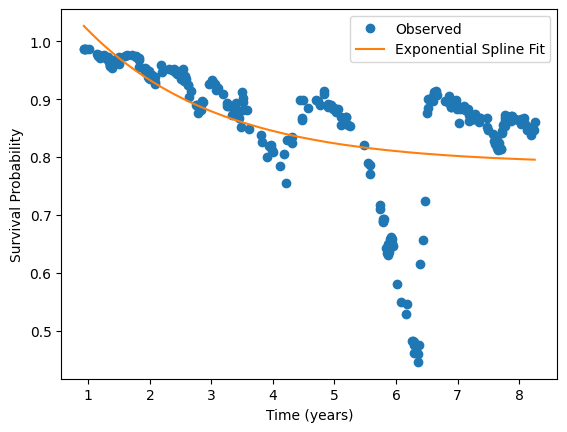

In [145]:
# Create fitted curve
df['Q_fit'] = exp_spline(df['Time_to_Maturity'], *params)

plt.plot(df['Time_to_Maturity'], df['s_tau'], 'o', label="Observed")
plt.plot(df['Time_to_Maturity'], df['Q_fit'], '-', label="Exponential Spline Fit")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()


In [146]:
df_survival = df.loc[:, ['date', 's_tau', 'Q_fit']]
df_survival['date'] = pd.to_datetime(df_survival['date'])
df_survival = df_survival.resample('ME', on='date').mean()
df_survival.reset_index(inplace=True)

**Next step is to price with the survival based framework**

In [147]:
#Bond information
from datetime import datetime

coupon_freq = 2 # semi-annual
coupon_rate = 0.0375/coupon_freq
issue_date = datetime(2014, 7, 28)
first_coupon_date = datetime(2015, 3, 3)
par = 1000
coupon_amount = par * coupon_rate
maturity =  datetime(2026, 9, 3)

##Havinng a problem adding the final payment here
dates = pd.date_range(start=first_coupon_date, end=maturity, freq='6MS').tolist()
if dates[-1] < maturity:
    dates.append(maturity)
    
    
    
schedule = []

for d in dates:
    cashflow = coupon_amount
    principal = 0
    if d == maturity:
        cashflow += par
        principal = par
    schedule.append({
        "date": d,
        "cashflow": cashflow,
        "coupon": coupon_amount,
        "principal": principal
    })

df_schedule = pd.DataFrame(schedule)
df_schedule#.head()

,date,cashflow,coupon,principal
0,2015-04-01,18.75,18.75,0
1,2015-10-01,18.75,18.75,0
2,2016-04-01,18.75,18.75,0
3,2016-10-01,18.75,18.75,0
4,2017-04-01,18.75,18.75,0
5,2017-10-01,18.75,18.75,0
6,2018-04-01,18.75,18.75,0
7,2018-10-01,18.75,18.75,0
8,2019-04-01,18.75,18.75,0
9,2019-10-01,18.75,18.75,0


In [148]:
df_risk_free = pd.read_csv(r"C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\3M_treasury_yields.csv")
df_risk_free.rename(columns ={'observation_date': 'date', 'DGS3MO': 'risk_free_rate'}, inplace=True)
df_risk_free['date'] = pd.to_datetime(df_risk_free['date'])
df_risk_free

,date,risk_free_rate
0,2015-04-01,0.01
1,2015-05-01,0.01
2,2015-06-01,0.01
3,2015-07-01,0.08
4,2015-08-01,0.08
...,...,...
122,2025-06-01,4.41
123,2025-07-01,4.41
124,2025-08-01,4.23
125,2025-09-01,4.02


In [165]:
def match_risk_free_rates(df_schedule, df_risk_free, df_survival=None):
    """
    Match risk-free rates and survival probabilities to bond cashflows based on year-month
    
    Parameters:
    df_schedule: DataFrame with bond cashflow schedule
    df_risk_free: DataFrame with risk-free rates
    df_survival: DataFrame with survival probabilities (Q_fit column)
    
    Returns:
    DataFrame with matched risk-free rates and survival probabilities
    """
    # Create a copy to avoid modifying original
    df_matched = df_schedule.copy()
    
    # Convert dates to datetime if they aren't already
    df_matched['date'] = pd.to_datetime(df_matched['date'])
    df_risk_free_copy = df_risk_free.copy()
    df_risk_free_copy['date'] = pd.to_datetime(df_risk_free_copy['date'])
    
    # Create year-month columns for matching
    df_matched['year_month'] = df_matched['date'].dt.to_period('M')
    df_risk_free_copy['year_month'] = df_risk_free_copy['date'].dt.to_period('M')
    
    # Merge risk-free rates on year-month
    df_matched = df_matched.merge(
        df_risk_free_copy[['year_month', 'risk_free_rate']], 
        on='year_month', 
        how='left'
    )
    
    # If survival data is provided, merge Q_fit as well
    if df_survival is not None:
        df_survival_copy = df_survival.copy()
        df_survival_copy['date'] = pd.to_datetime(df_survival_copy['date'])
        df_survival_copy['year_month'] = df_survival_copy['date'].dt.to_period('M')
        
        df_matched = df_matched.merge(
            df_survival_copy[['year_month', 'Q_fit']], 
            on='year_month', 
            how='left'
        )
    
    # Drop the temporary year_month column
    df_matched = df_matched.drop('year_month', axis=1)
    
    return df_matched

# Apply the function with both risk-free rates and survival probabilities
df_schedule_with_rates = match_risk_free_rates(df_schedule, df_risk_free, df_survival)
df_schedule_with_rates.replace(np.nan, 0, inplace=True)
df_schedule_with_rates#.to_clipboard()

,date,cashflow,coupon,principal,risk_free_rate,Q_fit
0,2015-04-01,18.75,18.75,0,0.01,0.000000
1,2015-10-01,18.75,18.75,0,0.08,0.000000
2,2016-04-01,18.75,18.75,0,0.22,0.000000
3,2016-10-01,18.75,18.75,0,0.34,0.000000
4,2017-04-01,18.75,18.75,0,0.80,0.000000
5,2017-10-01,18.75,18.75,0,1.15,0.000000
6,2018-04-01,18.75,18.75,0,1.87,0.000000
7,2018-10-01,18.75,18.75,0,2.34,0.796962
8,2019-04-01,18.75,18.75,0,2.43,0.799532
9,2019-10-01,18.75,18.75,0,1.54,0.802600


In [163]:
df_survival.head(50)
df[125:175]

,date,Time_to_Maturity,last_value,spread_bps,spread_dec,hazard,s_tau,Q_fit
125,2021-08-25,5.027397,155.630,155.630,0.015563,0.025938,0.877742,0.823216
126,2021-09-07,4.991781,146.627,146.627,0.014663,0.024438,0.885159,0.823811
127,2021-09-10,4.983562,148.775,148.775,0.014878,0.024796,0.883758,0.823950
128,2021-09-27,4.936986,142.307,142.307,0.014231,0.023718,0.889501,0.824746
129,2021-09-30,4.928767,141.466,141.466,0.014147,0.023578,0.890289,0.824889
130,2021-10-12,4.895890,146.738,146.738,0.014674,0.024456,0.887155,0.825464
131,2021-10-14,4.890411,141.162,141.162,0.014116,0.023527,0.891316,0.825560
132,2021-11-03,4.835616,112.588,112.588,0.011259,0.018765,0.913256,0.826541
133,2021-11-08,4.821918,119.595,119.595,0.011959,0.019932,0.908361,0.826790
134,2021-11-29,4.764384,148.002,148.002,0.014800,0.024667,0.889120,0.827853


In [150]:
#Now we have everything to price, we need to drop 0 value and get more data for the bonds